# 2. Source Detection and Aperture Photometry for Cropped Region 2

In this step, we will do the following items:
* Perform sources detection and extraction
* Perform aperture photometry process to measure fluxes and get the spectral energy distributions of the detected sources. 

We will do all of these processes using [SEP](https://sep.readthedocs.io/en/v1.0.x/index.html), which is a python version of [SExtractor](https://www.astromatic.net/software/sextractor/) ([Bertin & Arnouts 1996](https://ui.adsabs.harvard.edu/abs/1996A%26AS..117..393B/abstract)). 

**Our goal here is to produce a photometric catalog containing coordinates and the spectral energy distribution of detected objects in cropped region**.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

List input images along with the set of filters. The input images here are the results of the PSF matching we did in the Step 1.

In [2]:
# list of filters and their names
filters = ['jwst_nircam_f115w', 'jwst_nircam_f150w', 'jwst_nircam_f200w', 'jwst_nircam_f277w',
           'jwst_nircam_f356w', 'jwst_nircam_f444w']

# number of filters
nbands = len(filters)

# Wavelength of the filters
photo_wave = [11540.0, 15010.0, 19890.0, 27620.0, 35680.0, 44080.0]

# Names of science images
sci_img = ['psfmatch_crop2_ceers5_f115w_sci.fits.gz', 'psfmatch_crop2_ceers5_f150w_sci.fits.gz', 
           'psfmatch_crop2_ceers5_f200w_sci.fits.gz', 'psfmatch_crop2_ceers5_f277w_sci.fits.gz', 
           'psfmatch_crop2_ceers5_f356w_sci.fits.gz', 'crop2_ceers5_f444w_sci.fits.gz']

# Names of variance images
var_img = ['psfmatch_crop2_var_ceers5_f115w_err.fits.gz', 'psfmatch_crop2_var_ceers5_f150w_err.fits.gz', 
           'psfmatch_crop2_var_ceers5_f200w_err.fits.gz', 'psfmatch_crop2_var_ceers5_f277w_err.fits.gz', 
           'psfmatch_crop2_var_ceers5_f356w_err.fits.gz', 'crop2_var_ceers5_f444w_err.fits.gz']

# pixel scale of the images
pixsize = 0.03

## 2.1. Source Detection and Extraction

We will use SEP for detecting sources and get the segmentation maps of them. For this example, let's base our detection on F150W band.

In [3]:
import sep

# get data image
hdu = fits.open('psfmatch_crop2_ceers5_f150w_sci.fits.gz')
data_sci = hdu[0].data
hdu.close()

data_sci = data_sci.byteswap(inplace=True).newbyteorder()

# get variance image
hdu = fits.open('psfmatch_crop2_var_ceers5_f150w_err.fits.gz')
data_var = hdu[0].data
hdu.close()

data_var = data_var.byteswap(inplace=True).newbyteorder()
data_err = np.sqrt(data_var)

objects, segmap = sep.extract(data_sci, thresh=2.0, err=data_err, minarea=5, 
                      deblend_nthresh=32, deblend_cont=0.005, segmentation_map=True)

In [4]:
# Number of detected objects
nobj = len(objects)
print (nobj)

483


### Show detected objects

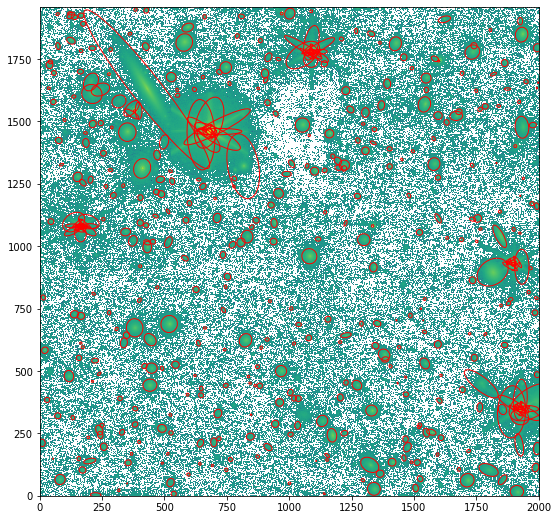

In [6]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(np.log10(data_sci), origin='lower')

# plot an ellipse for each object
for i in range(nobj):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i]*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

### Show segmentation maps

Segmentation map is a map showing the membership of pixels. Pixels belong to the same object will have the same value. This value is the index of the object in the SEP catalog. 

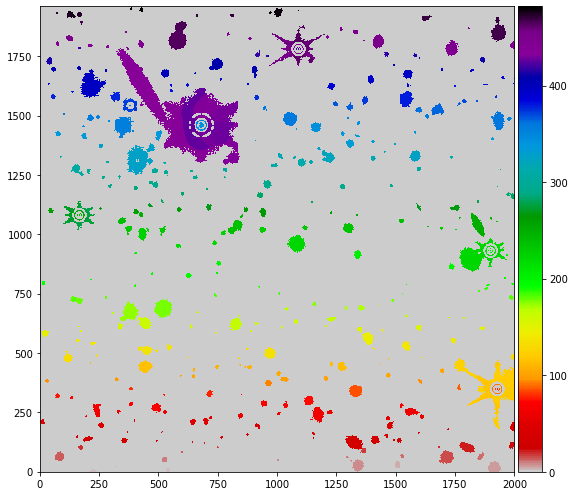

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(9,9))
f1 = plt.subplot()

im = plt.imshow(segmap, origin='lower', cmap='nipy_spectral_r')
divider = make_axes_locatable(f1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## 2.2. Aperture Photometry to get SEDs of detected objects

Spectral energy distribution (SED) is fluxes measured at multiple bands. In photometry, the SED can be regareded as spectrum with a very low spectral resolution.

For this tutorial, we will compute aperture photometry based on circular aperture with a radius of 10 pixels or 0.3 arcsec (in image with 0.03 arcsec/pixel).

In [5]:
# circular aperture radius
aper_radius = 10.0                     # in pixel (corresponds to 0.3 arcsec)

flux0 = np.zeros((nbands,nobj))
fluxerr0 = np.zeros((nbands,nobj))
flag0 = np.zeros((nbands,nobj))
for bb in range(0,nbands):
    hdu = fits.open(sci_img[bb])
    data_sci = hdu[0].data
    hdu.close()
    
    data_sci = data_sci.byteswap(inplace=True).newbyteorder()
    
    hdu = fits.open(var_img[bb])
    data_var = hdu[0].data
    hdu.close()
    
    data_var = data_var.byteswap(inplace=True).newbyteorder()
    data_err = np.sqrt(data_var)
    
    flux0[bb], fluxerr0[bb], flag0[bb] = sep.sum_circle(data_sci, objects['x'], objects['y'],
                                                 aper_radius, err=data_err, gain=1.0)
    
    # change nan or inf
    idx_ch = np.where(np.isnan(flux0[bb])==True)
    flux0[bb][idx_ch[0]] = -99.0
    
    idx_ch = np.where(np.isnan(fluxerr0[bb])==True)
    fluxerr0[bb][idx_ch[0]] = -99.0
  

In [6]:
# transpose from (band-id, obj-id) to (obj-id, band-id)
flux = np.transpose(flux0, axes=(1,0))
fluxerr = np.transpose(fluxerr0, axes=(1,0))
flag = np.transpose(flag0, axes=(1,0))

In [7]:
from astropy.table import QTable

fname = ['f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']

idx = np.arange(nobj)
data_table = []
names = []
data_table.append(idx)
names.append('ID')
data_table.append(objects['x'])
names.append('x')
data_table.append(objects['y'])
names.append('y')
for bb in range(0,nbands):
    data_table.append(flux0[bb])
    names.append('f_%s' % fname[bb])
    data_table.append(fluxerr0[bb])
    names.append('fe_%s' % fname[bb])
    
names = tuple(names)

t = QTable(data_table, names=names, meta={'name': 'catalog'})

In [8]:
t

ID,x,y,f_f115w,fe_f115w,f_f150w,fe_f150w,f_f200w,fe_f200w,f_f277w,fe_f277w,f_f356w,fe_f356w,f_f444w,fe_f444w
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,1140.5145986237135,7.976413758422279,0.772918786157097,0.8886359615598349,0.8165395007117513,0.9190003620535854,1.3227377288599387,1.1584305938332773,1.3513536521594505,1.1639337307210822,1.2611261755822483,1.123860769731815,1.6725916553719342,1.296457633529935
1,224.58941722067286,3.5189707542026802,2.891314608925896,1.7041882359847862,3.775896471329034,1.9489488357310418,5.045462760198861,2.2497175476186704,5.642041490497067,2.3759747176780714,6.066025529447943,2.463308892055786,5.708196611276363,2.390658598048346
2,537.1369948437115,7.458686957984798,8.570880828427612,2.9306093528596957,7.8073000096855685,2.7996303994696756,9.682532612401994,3.115209242191324,10.825312195140869,3.290847848344163,10.322261680047955,3.213212832591835,10.205255228852021,3.195759426960978
3,317.20458904295407,21.514678164463916,1.2254917501091958,1.1153702082506378,1.2783117526664862,1.1435326106214332,1.0639645143217962,1.0412207458027474,1.373743869073442,1.1735874444149874,1.438329831452247,1.2001488339594653,1.4156635934249249,1.1933323702251333
4,1506.4674580188162,30.65240803897474,8.242954937306353,2.8744987347987205,21.41486439431087,4.631954664145196,39.68357989899815,6.302400242880657,74.85124676331878,8.652312623830298,126.24266475930811,11.236205397689954,162.98559299439194,12.767608605605925
5,1912.6417800210834,16.481823985451136,27.49519888743759,5.2461446867654145,52.078525246530795,7.220444167518611,107.58433535575868,10.375422666109717,148.57748831331725,12.19003082901592,198.94854794740672,14.105450691089993,247.4120285820961,15.730506211590159
6,350.3967985472968,49.19715952577289,0.7745197379967022,0.8903697610560302,0.6540760488009255,0.8267725871862165,1.4981961938471064,1.2322405610301084,1.485656207807479,1.2204162833065428,1.3467263436075878,1.161367189299667,1.0803604961802196,1.0435767563452556
7,1001.2918157917325,49.40633710914515,1.160394793530887,1.0851549300832593,1.8118813248350671,1.357234753247188,2.228431802949273,1.4996865334397251,2.187761335041614,1.4803547574462053,1.9593486018481965,1.4004942900833695,1.9650111220659887,1.4048042395732916
8,1339.4514584094234,27.43817391995374,24.50506122753025,4.952718236811552,40.9977315273881,6.406854926134863,52.78786840647457,7.2684061722528766,68.89368200153113,8.300869245421131,75.61625154435637,8.696131387534423,83.02411338090899,9.112712248034754


## 2.3. Convert surface brightness from MJy/sr to micro-Jy and erg/s/cm^2/A

JWST data units: MJy/sr

Mega Janskys (MJy); mag_AB = 8.9 - 2.5 log10(flux_Jy) = 31.4 - 2.5 log10(flux_nJy)

steradian (sr) = 4.255e+10 arcsec^2

In [9]:
arcsec2_per_sr = 4.25e+10
#sr_per_pix = sr_per_arcsec2*arcsec2_per_pix
sr_per_pix = pixsize*pixsize/arcsec2_per_sr

## convert to uJy
flux_uJy = flux*sr_per_pix*1e+12
fluxerr_uJy = fluxerr*sr_per_pix*1e+12

## convert to erg/s/cm^2
flux_ergscmA = flux_uJy*1e-6*1.0e-23*2.998e+18/photo_wave/photo_wave
fluxerr_ergscmA = fluxerr_uJy*1e-6*1.0e-23*2.998e+18/photo_wave/photo_wave

## 2.4. Calculate AB magnitudes

In [10]:
# AB magnitude
mag_AB = 8.9 - 2.5*np.log10(flux_uJy*1e-6)

# AB magnitude uncertainty
mag_AB_err = 2.5*np.log10(1 + fluxerr/flux)

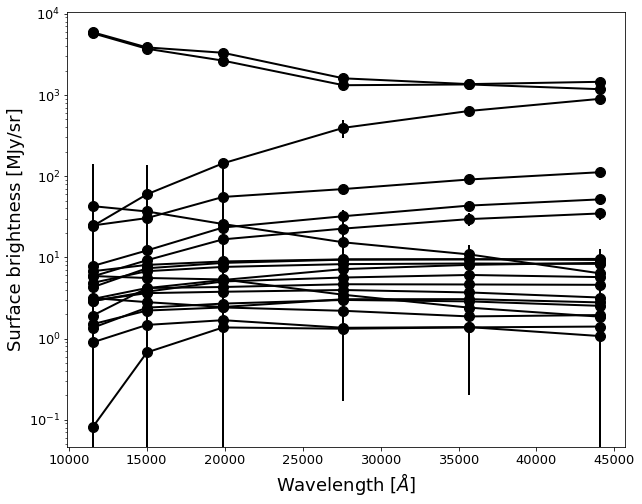

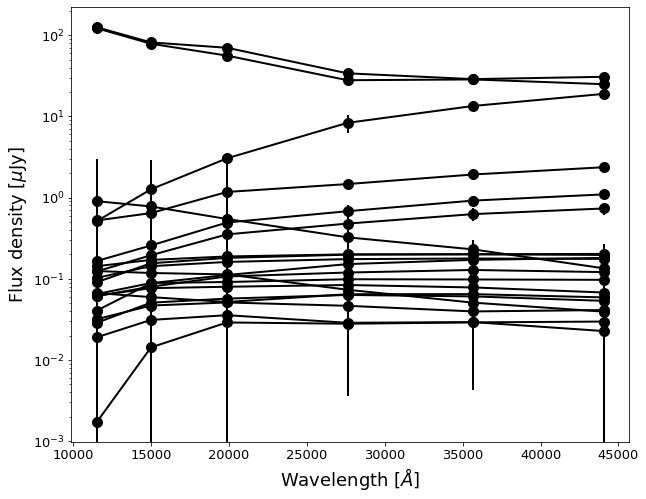

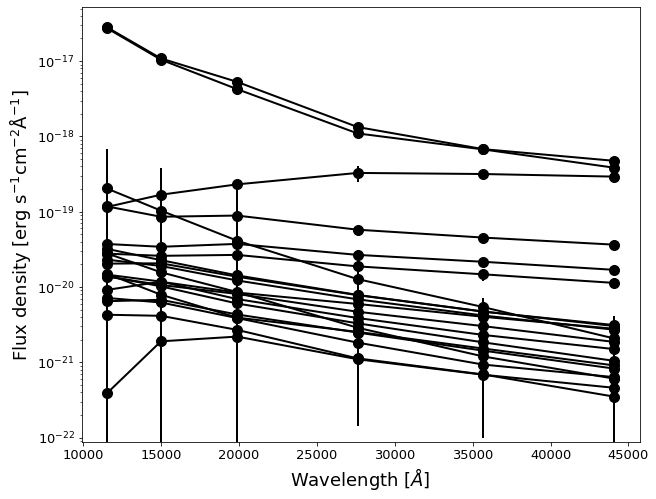

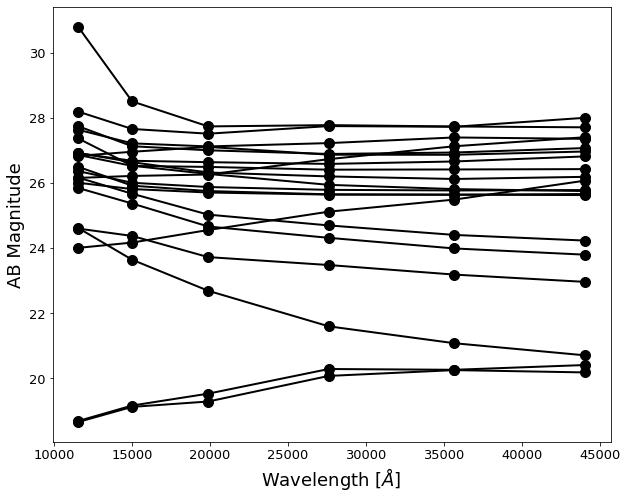

In [11]:
# choose 20 random objects
idx = np.random.randint(0,nobj-1,20)


# plot SED in surface brightness unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Surface brightness [MJy/sr]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux[idx[ii]], yerr=fluxerr[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in flux density (micro Jy) unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Flux density [$\mu$Jy]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux_uJy[idx[ii]], yerr=fluxerr_uJy[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in flux density (erg/s/cm^2/A) unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Flux density [erg $\rm{ s}^{-1}\rm{cm}^{-2}\AA^{-1}$]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux_ergscmA[idx[ii]], yerr=fluxerr_ergscmA[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in AB magnitude
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"AB Magnitude", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, mag_AB[idx[ii]], yerr=fluxerr_ergscmA[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()

## 2.5. Make photometric catalog

We will store results of our aperture photometry into a catalog named `ceers_crop2_photo.cat`. We will also include the coordinates of the galaxies. Since we only have cartesian coordinates from SEP, we need to convert that back to sky coordinates.

In [12]:
# Get sky coordinates of the detected objects
from astropy.wcs import WCS

hdu = fits.open('psfmatch_crop2_ceers5_f150w_sci.fits.gz')
wcs = WCS(hdu[0].header)
hdu.close()

obj_ra, obj_dec = wcs.wcs_pix2world(objects['x'], objects['y'], 1)

In [16]:
# make photometric catalog: flux in erg/s/cm^2/A
file_out = open("ceers_crop2_photo.cat","w")
file_out.write("#(1)id (2)x (3)y (4)ra (5)dec (6)f_f115w (7)e_f115w (8)f_f150w (9)e_f150w (10)f_f200w (11)e_f200w (12)f_f277w (13)e_f277w (14)f_f356w (15)e_f356w (16)f_f444w (17)e_f444w \n")
file_out.write("# All flux densisties are in units of erg/s/cm^2/Angstrom \n")
for ii in range(0,nobj):
    file_out.write("%d %lf %lf %lf %lf " % (ii+1,objects['x'][ii],objects['y'][ii],obj_ra[ii],obj_dec[ii]))
    for bb in range(0,nbands-1):
        file_out.write("%e %e " % (flux_ergscmA[ii][bb],fluxerr_ergscmA[ii][bb]))
    file_out.write("%e %e\n" % (flux_ergscmA[ii][int(nbands)-1],fluxerr_ergscmA[ii][int(nbands)-1]))

file_out.close()

## 2.6. Make input photometric catalog for photometric redshift with EAZY

In this step, we prepare an input catalog for performing photometric redshift using EAZY software.

In [13]:
file_out = open('ceers_eazy_input_crop2.cat', 'w')
file_out.write('#id f_f115w e_f115w f_f150w e_f150w f_f200w e_f200w f_f277w e_f277w f_f356w e_f356w f_f444w e_f444w z_spec\n')
file_out.write('#id F364 E364 F365 E365 F366 E366 F375 E375 F376 E376 F377 E377 z_spec\n')

for ii in range(0,nobj):
    file_out.write("%d  " % (ii+1))
    for bb in range(0,nbands):
        file_out.write("%e  %e  " % (flux_uJy[ii][bb],fluxerr_uJy[ii][bb]))
    file_out.write("-1.000\n")

file_out.close()